### Импорт всех зависимостей

In [2]:
!pip install torch
!pip install torchvision
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from itertools import product


## Датасет

Был выбран датасет из PyTorch **[MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)**

**MNIST** — это популярный датасет изображений **цифр**.

Каждое изображение в датасете размером: 28 × 28 пикселей..

 #### Константы

In [4]:
batch_size = 64
epochs_count = 10
learning_rates = [1e-4]
weight_decay = 1e-4

in_features = 28 * 28
hidden_size = 256
out_features = 10
weight_decay = 0.001

proportions_train_validate_datasets = [0.8, 0.2]
size_px = 28

### Подготовка данных

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

train_dataset = MNIST(root='./datasets', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./datasets', train=False, transform=transform, download=True)
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * x) for x in proportions_train_validate_datasets])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


print(f"Training Examples: {len(train_dataset)}, Validation Examples: {len(val_dataset)}, Testing Examples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.91MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.70MB/s]

Training Examples: 48000, Validation Examples: 12000, Testing Examples: 10000


### Пример батча изображений train_dataset и test_dataset

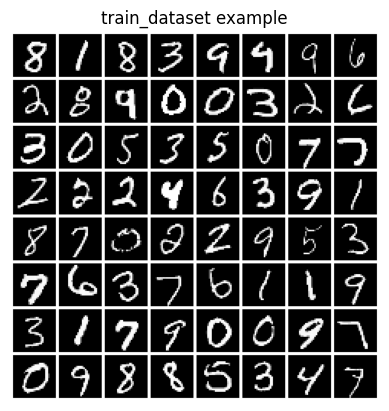

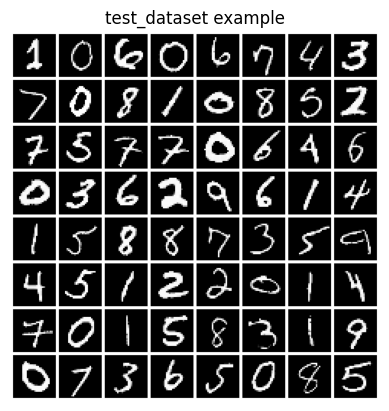

In [6]:
def show_plots_batch(dataset_loader, title = None):
    img_batch, _ = next(iter(dataset_loader))
    img = torchvision.utils.make_grid(img_batch, padding=2, pad_value=1)
    np_img = img.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    np_img = np.clip(np_img, 0, 1)
    plt.imshow(np_img)
    plt.axis('off')
    plt.title(title)
    plt.show()

show_plots_batch(train_loader, title="train_dataset example")
show_plots_batch(train_loader, title="test_dataset example")

## Реализуем необходимые классы

#### Классы слоёв **FullyConnectedLayer** и **ReluLayer**

In [7]:
class FullyConnectedLayer:
    def __init__(self, in_features, out_features, weight_decay=0.001):
        self.weight = torch.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.bias = torch.zeros(out_features)
        self.grad_weight = torch.zeros_like(self.weight)
        self.grad_bias = torch.zeros_like(self.bias)
        self.weight_decay = weight_decay
        self.saved_input = None

    def forward(self, x):
        self.saved_input = x
        return x @ self.weight + self.bias

    def backward(self, grad_output):
        x = self.saved_input
        self.grad_weight = x.T @ grad_output + self.weight_decay * self.weight
        self.grad_bias = torch.sum(grad_output, dim=0)
        grad_input = grad_output @ self.weight.T
        return grad_input

    def parameters(self):
        return [self.weight, self.bias]

    def gradients(self):
        return [self.grad_weight, self.grad_bias]

class ReluLayer:
    def __init__(self):
        self.saved_input = None

    def forward(self, x):
        self.saved_input = x
        return x.clamp(min=0)

    def backward(self, grad_output):
        mask = (self.saved_input > 0).float()
        return grad_output * mask


In [8]:
class BatchNormalizationLayer:
    def __init__(self, num_features, momentum=0.1, eps=1e-5):
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

        self.grad_gamma = torch.zeros_like(self.gamma)
        self.grad_beta = torch.zeros_like(self.beta)

        self.momentum = momentum
        self.eps = eps

        self.training = True
        self.cache = None

    def forward(self, x):
        if self.training:
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

            self.x_centered = x - batch_mean
            self.std_inv = 1.0 / torch.sqrt(batch_var + self.eps)

            x_norm = self.x_centered * self.std_inv
            self.x_norm = x_norm
        else:
            x_norm = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        out = self.gamma * x_norm + self.beta
        return out

    def backward(self, grad_output):
        N = grad_output.shape[0]

        self.grad_gamma = torch.sum(grad_output * self.x_norm, dim=0)
        self.grad_beta = torch.sum(grad_output, dim=0)

        dx_norm = grad_output * self.gamma

        dvar = torch.sum(dx_norm * self.x_centered, dim=0) * -0.5 * self.std_inv**3
        dmean = torch.sum(dx_norm * -self.std_inv, dim=0) + dvar * torch.mean(-2.0 * self.x_centered, dim=0)

        dx = dx_norm * self.std_inv + dvar * 2 * self.x_centered / N + dmean / N
        return dx

    def parameters(self):
        return [self.gamma, self.beta]

    def gradients(self):
        return [self.grad_gamma, self.grad_beta]

    def zero_grad(self):
        self.grad_gamma.zero_()
        self.grad_beta.zero_()

    def train(self):
        self.training = True

    def eval(self):
        self.training = False


#### Класс нейронной сети **NeutalNetwork**

In [9]:
class NeutalNetwork:
    def __init__(self, in_features, out_features, hidden_size, weight_decay, batch_normalization=False):
        super().__init__()

        self.layers = []
        self.layers.append(FullyConnectedLayer(in_features, hidden_size))

        # Strictly before ReLu
        if batch_normalization:
            self.layers.append(BatchNormalizationLayer(hidden_size))

        self.layers.append(ReluLayer())
        self.layers.append(FullyConnectedLayer(hidden_size, out_features))

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x


    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output

    def parameters(self):
        params = []
        for layer in self.layers:
            if hasattr(layer, "parameters"):
                params.extend(layer.parameters())
        return params

    def gradients(self):
        grads = []
        for layer in self.layers:
            if hasattr(layer, "gradients"):
                grads.extend(layer.gradients())
        return grads

    def train(self):
        for layer in self.layers:
            if isinstance(layer, BatchNormalizationLayer):
                layer.train()

    def eval(self):
        for layer in self.layers:
            if isinstance(layer, BatchNormalizationLayer):
                layer.eval()

### Реализация оптимизатора Адама

In [10]:
class Adam:
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.exp_avg = [torch.zeros_like(p) for p in parameters]
        self.exp_avg_sq = [torch.zeros_like(p) for p in parameters]
        self.step_count = 0

    def step(self, gradients):
        self.step_count += 1
        for i in range(len(self.parameters)):
            self.exp_avg[i] = self.beta1 * self.exp_avg[i] + (1 - self.beta1) * gradients[i]
            self.exp_avg_sq[i] = self.beta2 * self.exp_avg_sq[i] + (1 - self.beta2) * (gradients[i] ** 2)

            bias_correction1 = 1 - self.beta1 ** self.step_count
            bias_correction2 = 1 - self.beta2 ** self.step_count

            corrected_exp_avg = self.exp_avg[i] / bias_correction1
            corrected_exp_avg_sq = self.exp_avg_sq[i] / bias_correction2

            self.parameters[i].data -= self.learning_rate * corrected_exp_avg / (torch.sqrt(corrected_exp_avg_sq) + self.epsilon)


### Реализация оптимизатора Momentum

In [11]:
class Momentum:
    def __init__(self, parameters, learning_rate=0.01, beta=0.9):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.velocities = [torch.zeros_like(p) for p in parameters]

    def step(self, grads):
        for i in range(len(self.parameters)):
            self.velocities[i] = self.beta * self.velocities[i] + grads[i]
            self.parameters[i].data -= self.learning_rate * self.velocities[i]

### Реализация класса CrossEntropyLoss

In [12]:
class CrossEntropyLoss:
    def __init__(self):
        self.saved_tensors = None

    def forward(self, logits, targets):
        maxes = torch.max(logits, 1, keepdim=True)[0]
        exp_logits = torch.exp(logits - maxes)
        probs = exp_logits / torch.sum(exp_logits, 1, keepdim=True)
        log_probs = torch.log(probs)
        loss = -log_probs[range(targets.size(0)), targets].mean()
        self.saved_tensors = (probs, targets)
        return loss

    def backward(self):
        probs, targets = self.saved_tensors
        batch_size = probs.shape[0]
        grad_logits = probs.clone()
        grad_logits[range(batch_size), targets] -= 1
        grad_logits /= batch_size
        return grad_logits

# Обучение с проверкой градиентов

In [13]:
def train_model(model, optimizer, num_epochs):
    criterion = CrossEntropyLoss()
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.view(x_batch.size(0), -1)
            logits = model.forward(x_batch)
            loss = criterion.forward(logits, y_batch)
            l2_reg = 0.0
            for layer in model.layers:
                if isinstance(layer, FullyConnectedLayer):
                    l2_reg += torch.sum(layer.weight**2) * (layer.weight_decay / 2)
            total_loss_batch = loss + l2_reg
            grad_logits = criterion.backward()
            model.backward(grad_logits)
            optimizer.step(model.gradients())
            total_loss += total_loss_batch.item() * x_batch.size(0)
            predicted = torch.argmax(logits, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.view(x_val.size(0), -1)
                logits = model.forward(x_val)
                loss = criterion.forward(logits, y_val)
                val_loss += loss * x_val.size(0)
                predicted = torch.argmax(logits, 1)
                correct += (predicted == y_val).sum().item()
                total += y_val.size(0)
        val_loss = val_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    return train_losses, train_accs, val_losses, val_accs

In [16]:
def model_test_score(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(inputs.size(0), -1)
            logits = model.forward(inputs)
            predicted = torch.argmax(logits, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    return correct / total


In [21]:
import itertools

configs = [
    {
        "optimizer_class": optimizer_class,
        "learning_rate": learning_rate,
        "batch_norm": batch_norm
    }
    for optimizer_class, learning_rate, batch_norm in itertools.product(
        [Momentum, Adam],
        [0.1, 0.01, 0.001, 0.0001],
        [True, False]
    )
]


def get_results(configs):
    best_model = None
    best_test_score = 0
    best_config = None
    res = {}

    for config in configs:
        optimizer_class = config["optimizer_class"]
        learning_rate = config["learning_rate"]
        batch_norm = config["batch_norm"]

        model = NeutalNetwork(in_features, out_features, hidden_size, weight_decay, batch_norm)
        optimizer = optimizer_class(model.parameters(), learning_rate=learning_rate)

        optimizer_name = optimizer_class.__name__
        print(f"Testing optimizer={optimizer_name}, rate={learning_rate}, batch_norm={batch_norm}")

        res[(optimizer_name, learning_rate, batch_norm)] = train_model(model, optimizer, epochs_count)

        if (score := model_test_score(model)) > best_test_score:
            best_test_score = score
            best_model = model
            best_config = optimizer_class.__name__, learning_rate


    return res, best_model, best_test_score, best_config



In [22]:
results, best_model, best_test_score, best_config = get_results(configs)

Testing optimizer=Momentum, rate=0.1, batch_norm=True
Epoch 1/10
Train Loss: 0.4390, Val Loss: 0.1345, Val Acc: 0.9577
Epoch 2/10
Train Loss: 0.2640, Val Loss: 0.1349, Val Acc: 0.9577
Epoch 3/10
Train Loss: 0.2287, Val Loss: 0.1210, Val Acc: 0.9624
Epoch 4/10
Train Loss: 0.2246, Val Loss: 0.1107, Val Acc: 0.9657
Epoch 5/10
Train Loss: 0.2196, Val Loss: 0.1119, Val Acc: 0.9651
Epoch 6/10
Train Loss: 0.2173, Val Loss: 0.1093, Val Acc: 0.9655
Epoch 7/10
Train Loss: 0.2134, Val Loss: 0.1129, Val Acc: 0.9666
Epoch 8/10
Train Loss: 0.2153, Val Loss: 0.1229, Val Acc: 0.9627
Epoch 9/10
Train Loss: 0.2199, Val Loss: 0.1050, Val Acc: 0.9706
Epoch 10/10
Train Loss: 0.2125, Val Loss: 0.1293, Val Acc: 0.9617
Testing optimizer=Momentum, rate=0.1, batch_norm=False
Epoch 1/10
Train Loss: inf, Val Loss: 1.5095, Val Acc: 0.4740
Epoch 2/10
Train Loss: 2.0047, Val Loss: 1.8198, Val Acc: 0.3018
Epoch 3/10
Train Loss: 2.1981, Val Loss: 2.0446, Val Acc: 0.2089
Epoch 4/10
Train Loss: 2.0841, Val Loss: 2.0469,

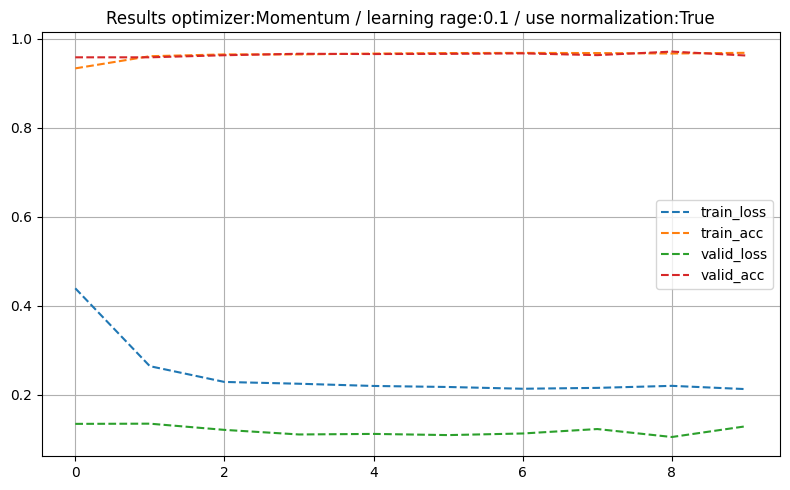

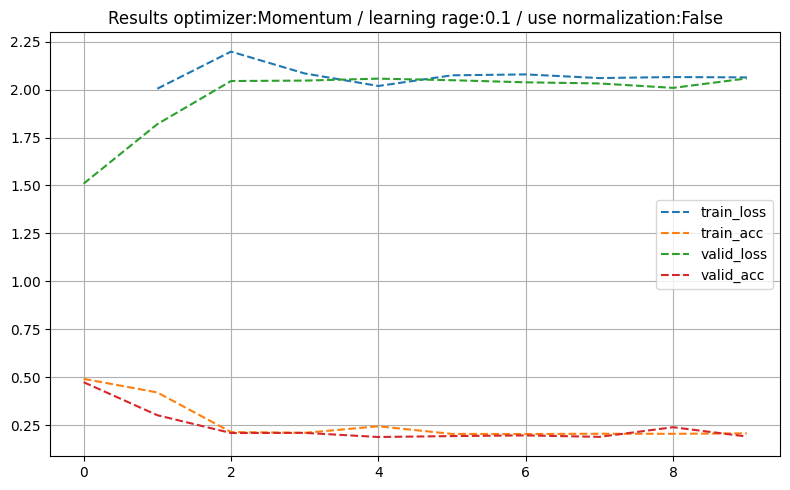

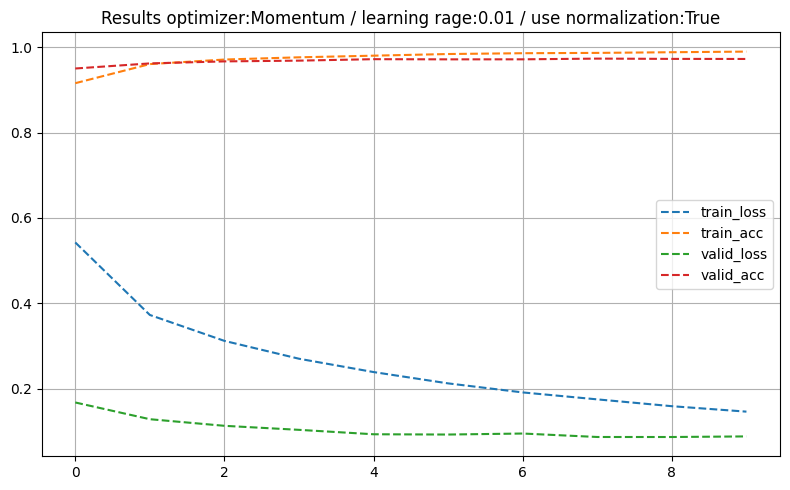

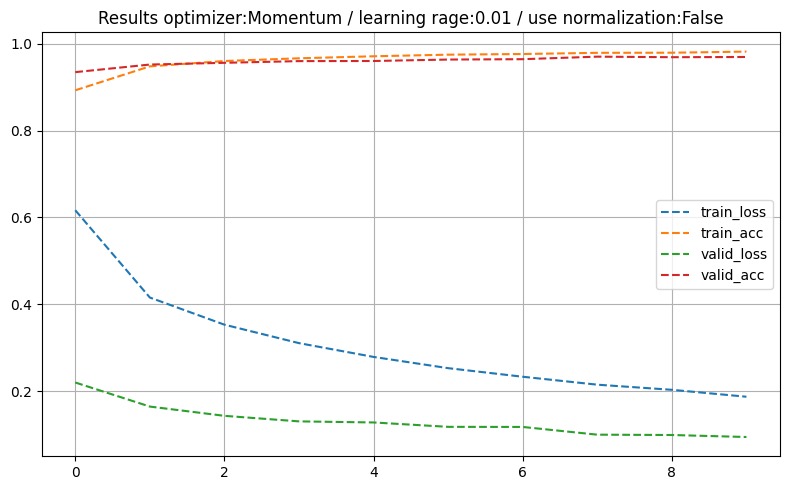

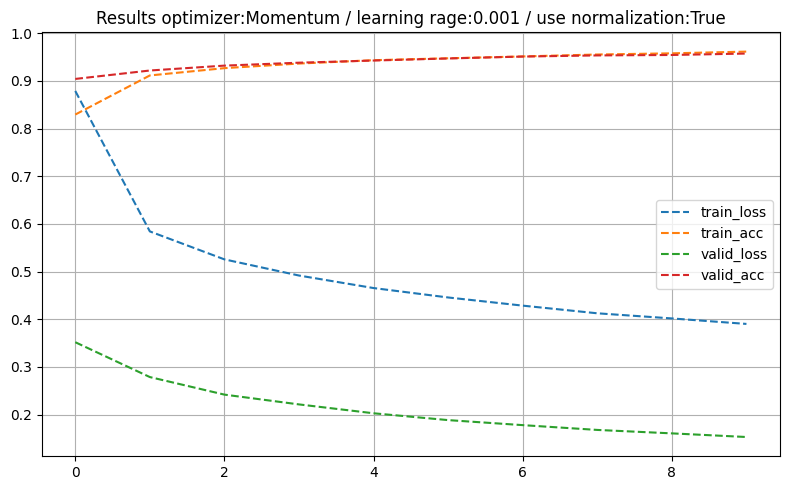

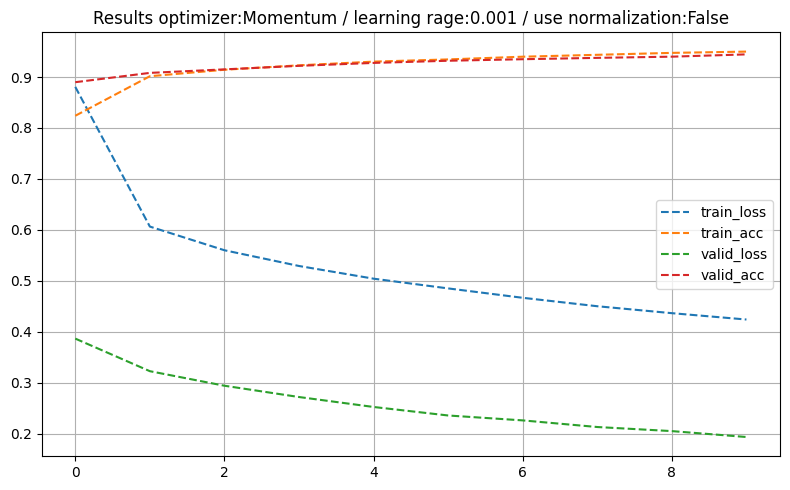

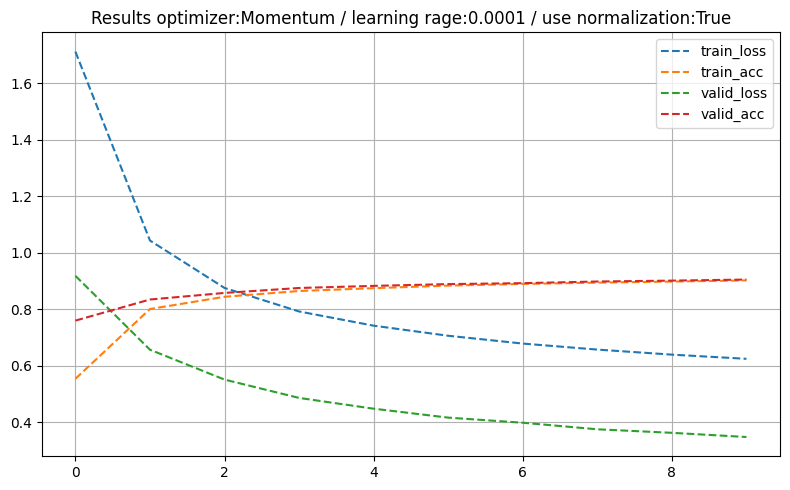

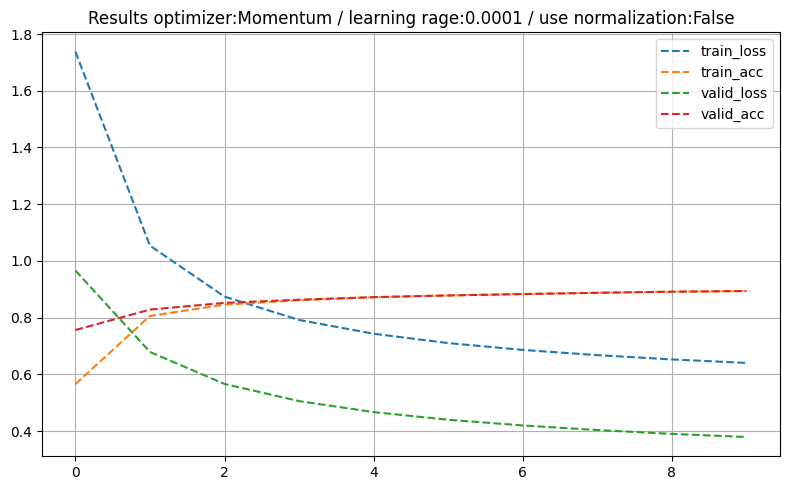

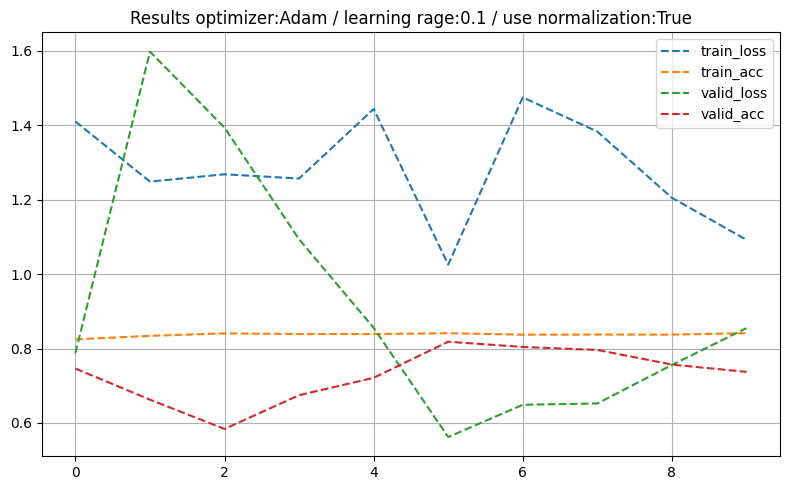

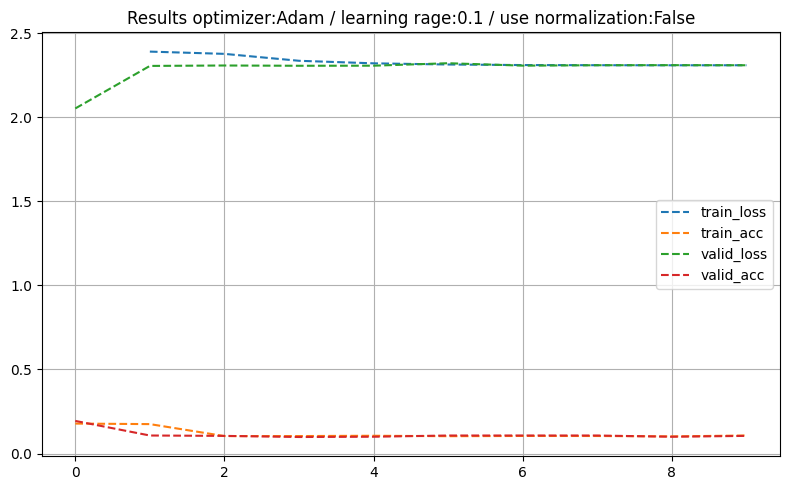

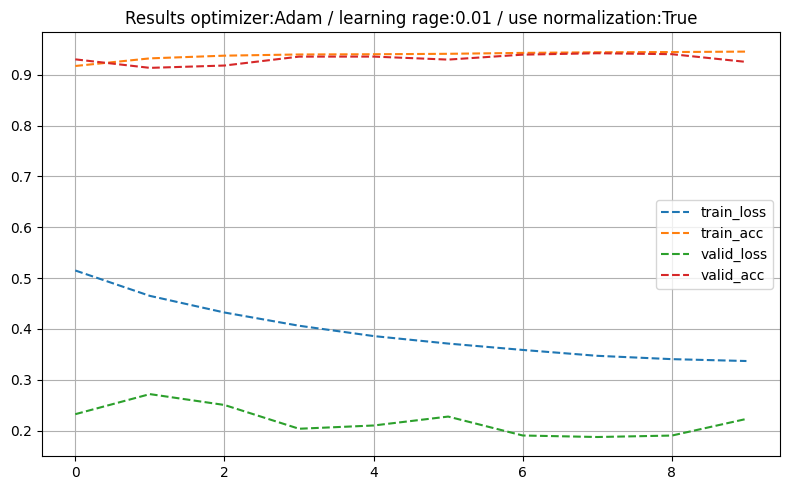

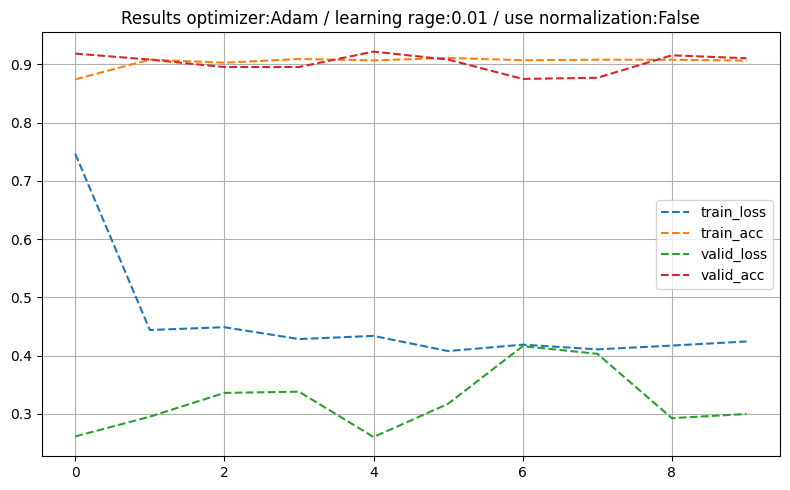

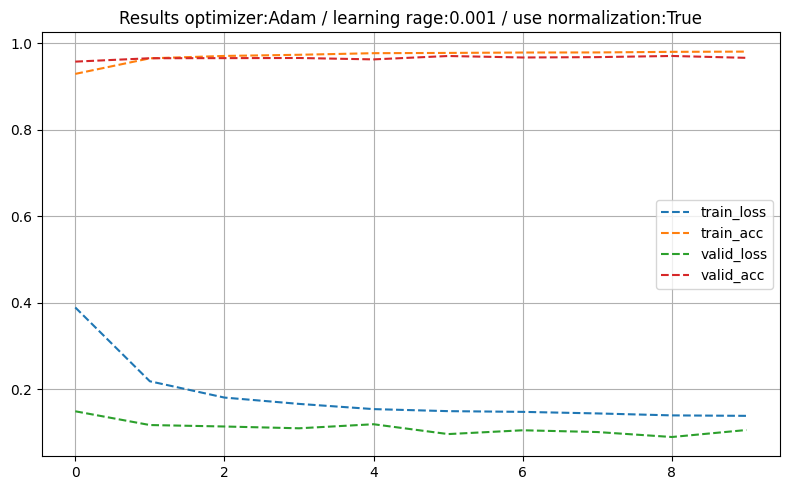

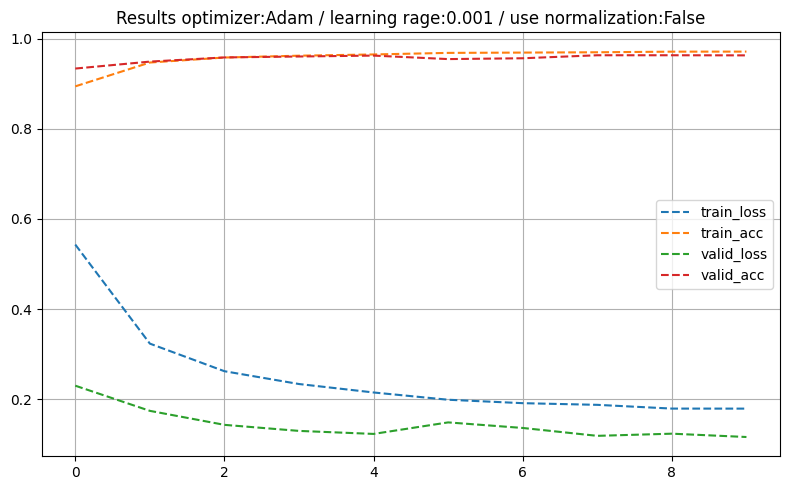

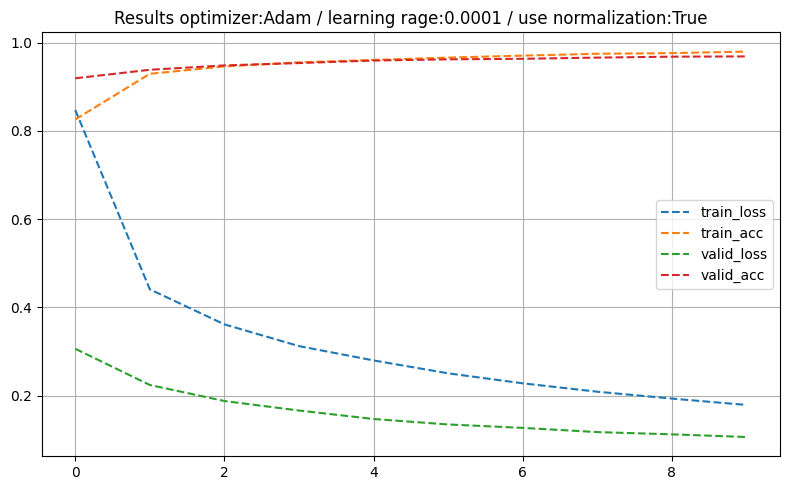

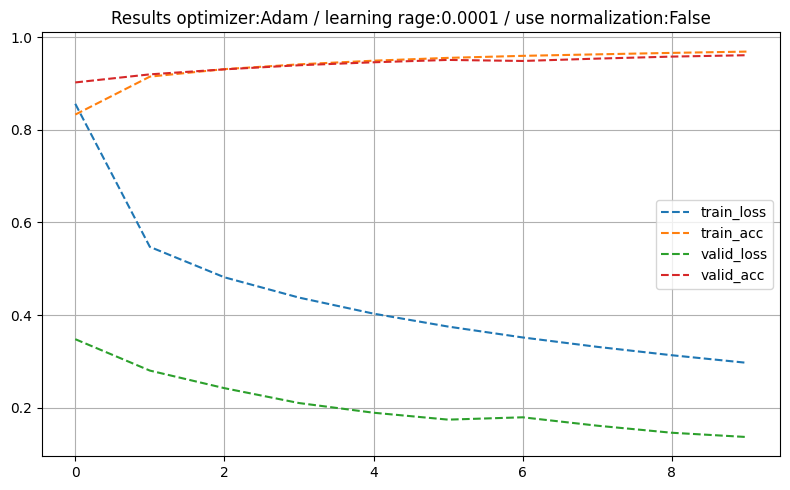

In [23]:
for tags, data in results.items():
    opt, lr, bn = tags
    plt.figure(figsize=(8, 5))
    plt.plot(data[0], label="train_loss", linestyle='dashed')
    plt.plot(data[1], label="train_acc", linestyle='dashed')
    plt.plot(data[2], label="valid_loss", linestyle='dashed')
    plt.plot(data[3], label="valid_acc", linestyle='dashed')
    plt.title(f"Results optimizer:{opt} / learning rage:{lr} / use normalization:{bn}")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
print(f'Best config: {best_config} / Best test score: {best_test_score}')

Best config: ('Momentum', 0.01) / Best test score: 0.9767


## Выводы

Лучшей комбинацией оказалась `Momentum` с `learing rate=0.01`. Эта модель показала точность в 97.67%.